In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/paysim1/PS_20174392719_1491204439457_log.csv
/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv


In [7]:
import pandas as pd
df_train_identity = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_identity.csv')
df_train_transaction = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_transaction.csv')
df_test_identity = pd.read_csv('/kaggle/input/ieee-fraud-detection/test_identity.csv')
df_test_transaction = pd.read_csv('/kaggle/input/ieee-fraud-detection/test_transaction.csv')

In [8]:
train = pd.merge(df_train_transaction, df_train_identity, on='TransactionID', how='left')
test = pd.merge(df_test_transaction, df_test_identity, on='TransactionID', how='left')

In [9]:
import gc
del df_train_transaction, df_train_identity, df_test_transaction, df_test_identity
gc.collect()

34

In [1]:
#train.columns.intersection(test.columns)
'isFraud' in test.columns.tolist()

NameError: name 'test' is not defined

In [5]:
#changes for column difference between train and test dataset 
#90% null columns need to be dropped individually from both datasets
missing_pct = train.isnull().sum() / len(train) * 100
cols_to_drop = missing_pct[missing_pct > 90].index
#print(cols_to_drop)
cols_to_drop = test.columns.intersection(cols_to_drop)
train = train.drop(columns=cols_to_drop,axis=1)
test = test.drop(columns=cols_to_drop,axis=1)

In [6]:
key_cols = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']
for col in key_cols:
    if col in train.columns:
        train[f'{col}_is_missing'] = train[col].isnull().astype('int8')
    if col in test.columns:
        test[f'{col}_is_missing'] = test[col].isnull().astype('int8')
        

In [7]:
#X_train.dtypes.unique()
num_cols = train.select_dtypes(include=['int64','float64','int8']).columns
cat_cols = train.select_dtypes(include=['O']).columns

In [8]:
#Filling Null values according to datatype
for col in num_cols:
    median_val = train[col].median()
    train[col] = train[col].fillna(median_val)
    if col in test.columns:
        test[col] = test[col].fillna(median_val)

for col in cat_cols:
    train[col] = train[col].fillna('missing')
    if col in test.columns:
        test[col] = test[col].fillna('missing')


In [9]:
train['TransactionDT'] = pd.to_datetime(train['TransactionDT'], unit='s')
new_cols = pd.DataFrame({
    'hour': train['TransactionDT'].dt.hour,
    'day': train['TransactionDT'].dt.dayofweek
}, index=train.index)
train = pd.concat([train, new_cols], axis=1)

test['TransactionDT'] = pd.to_datetime(test['TransactionDT'], unit='s')
new_cols = pd.DataFrame({
    'hour': test['TransactionDT'].dt.hour,
    'day': test['TransactionDT'].dt.dayofweek
}, index=train.index)
test = pd.concat([test, new_cols], axis=1)

del new_cols
gc.collect()



44

In [10]:
import numpy as np
train['log_TransactionAmt'] = np.log1p(train['TransactionAmt'])
test['log_TransactionAmt'] = np.log1p(test['TransactionAmt'])

/tmp/ipykernel_37/1400444268.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test['log_TransactionAmt'] = np.log1p(test['TransactionAmt'])


In [11]:
train['card1_count'] = train.groupby('card1')['TransactionID'].transform('count')
test['card1_count'] = test.groupby('card1')['TransactionID'].transform('count')

/tmp/ipykernel_37/1652041400.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test['card1_count'] = test.groupby('card1')['TransactionID'].transform('count')


In [12]:
for col in cat_cols:
    train[col] = train[col].astype('category')
    if col in test.columns:
        test[col] = test[col].astype('category')

In [13]:
pos_weight = (len(train[train['isFraud'] == 0]) / len(train[train['isFraud'] == 1]))

In [1]:

y_train = train['isFraud']
X_train = train.drop(['isFraud', 'TransactionID','TransactionDT'], axis=1)
X_test = test.drop(['TransactionID','TransactionDT'], axis=1)


NameError: name 'train' is not defined

In [15]:
y_train.to_pickle('Y_train_processed.pkl') 
X_train.to_parquet('X_train_processed.parquet',index=False) 
X_test.to_parquet('X_test_processed.parquet',index=False) 

In [3]:
paysim_df = pd.read_csv('/kaggle/input/paysim1/PS_20174392719_1491204439457_log.csv', dtype={'amount': 'float32', 'oldbalanceOrg': 'float32', 'newbalanceOrig': 'float32', 
                            'oldbalanceDest': 'float32', 'newbalanceDest': 'float32', 'isFraud': 'int8'})
print(paysim_df.head())

   step      type        amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.639648  C1231006815       170136.0   160296.359375   
1     1   PAYMENT   1864.280029  C1666544295        21249.0    19384.720703   
2     1  TRANSFER    181.000000  C1305486145          181.0        0.000000   
3     1  CASH_OUT    181.000000   C840083671          181.0        0.000000   
4     1   PAYMENT  11668.139648  C2048537720        41554.0    29885.859375   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


In [4]:
X_train = pd.read_parquet('/kaggle/working/X_train_processed.parquet')
y_train = pd.read_pickle('/kaggle/working/Y_train_processed.pkl')
print(X_train.head())
X_train['amt_mean_card1'] = X_train.groupby('card1')['TransactionAmt'].transform('mean')


   TransactionAmt ProductCD  card1  card2  card3       card4  card5   card6  \
0            68.5         W  13926  361.0  150.0    discover  142.0  credit   
1            29.0         W   2755  404.0  150.0  mastercard  102.0  credit   
2            59.0         W   4663  490.0  150.0        visa  166.0   debit   
3            50.0         W  18132  567.0  150.0  mastercard  117.0   debit   
4            50.0         H   4497  514.0  150.0  mastercard  102.0  credit   

   addr1  addr2  ...  M4_is_missing M5_is_missing M6_is_missing  \
0  315.0   87.0  ...              0             0             0   
1  325.0   87.0  ...              0             0             0   
2  330.0   87.0  ...              0             0             0   
3  476.0   87.0  ...              0             0             0   
4  420.0   87.0  ...              1             1             1   

   M7_is_missing  M8_is_missing  M9_is_missing  hour  day  log_TransactionAmt  \
0              1              1          

In [6]:
from sklearn.model_selection import train_test_split
X_train_ss, X_val_ss, y_train_ss, y_val_ss = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)
X_train_ss, X_val_ss, y_train_ss, y_val_ss = train_test_split(X_train_ss, y_train_ss, test_size=0.25,stratify=y_train_ss, random_state=42)




/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


False


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


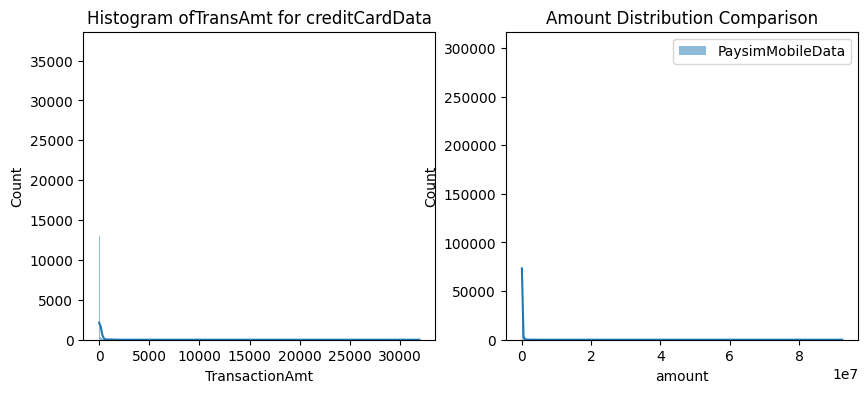

In [4]:
#Comparing histplot for paysim and ieee training data 
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

sns.histplot(X_train['TransactionAmt'],label='CreditCardData',kde=True,ax=axs[0])
axs[0].set_title("Histogram ofTransAmt for creditCardData")
paysim_amount= pd.to_numeric(paysim_df['amount'],errors='coerce')
print(np.isinf(paysim_amount).all())
#paysim_amount = paysim_amount.replace([np.inf, -np.inf], np.nan)
paysim_amount_c = paysim_amount[np.isfinite(paysim_amount)]#
axs[1].set_title("Histogram of Data 1")
sns.histplot(paysim_amount_c,label='PaysimMobileData',kde=True,ax=axs[1])
plt.legend()
plt.title('Amount Distribution Comparison')
plt.show()


In [5]:
print(X_train['ProductCD'].value_counts())
print(paysim_df['type'].value_counts())
X_train['amt_mean_card1'] = X_train.groupby('card1')['TransactionAmt'].transform('mean')
print("IEEE correlations:", X_train[['TransactionAmt', 'hour']].corrwith(y_train))
print("PaySim correlations:", paysim_df[['amount', 'oldbalanceOrg']].corrwith(paysim_df['isFraud']))

ProductCD
W    439670
C     68519
R     37699
H     33024
S     11628
Name: count, dtype: int64
type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64
IEEE correlations: TransactionAmt    0.011320
hour             -0.013112
dtype: float64
PaySim correlations: amount           0.076688
oldbalanceOrg    0.010154
dtype: float64


In [7]:
#merging paysim_df and X_train data 
X_CC_train = X_train.rename(columns={'TransactionAmt':'amount', 'ProductCD':'type'})
paysim_df = paysim_df.rename(columns={'step':'hour'})

X_CC_train['source'] = 0
paysim_df['source'] =1
paysim_df['source_transfer_amount'] = paysim_df['newbalanceOrig']-paysim_df['oldbalanceOrg']
common_cols = ['amount','hour','type','source']

X_merged = pd.concat([X_CC_train[common_cols + ['M1_is_missing','amt_mean_card1']],paysim_df[common_cols+['source_transfer_amount','oldbalanceOrg']]])

Y_merged = pd.concat([y_train,paysim_df['isFraud']],ignore_index=True)


In [8]:
from sklearn.utils import resample
fraud_paysim = paysim_df[paysim_df['isFraud'] == 1]
fraud_paysim_upsampled = resample(fraud_paysim, replace=True, n_samples=int(0.035 * len(paysim_df)), random_state=42)
paysim_balanced = pd.concat([paysim_df[paysim_df['isFraud'] == 0], fraud_paysim_upsampled])

In [12]:
#print(X_merged.dtypes)
from sklearn.preprocessing import LabelEncoder
nums_col = X_merged.select_dtypes(include=['float64','int64','float32']).columns
cat_col = X_merged.select_dtypes(include=['object']).columns

for col in nums_col:
    X_merged[col] = X_merged[col].fillna(X_merged[col].median())
for col in cat_col:
    X_merged[col] = X_merged[col].fillna('missing')

le = LabelEncoder()
X_merged['type'] = le.fit_transform(X_merged['type'].astype(str))

from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_merged[nums_col] = scaler.fit_transform(X_merged[nums_col])


In [14]:
X_merged.to_parquet('x_merged_training.parquet')
Y_merged.to_frame().to_parquet('y_merged_training.parquet')

In [2]:
#Implementing changes for the combined dataset model
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

X_merged = pd.read_parquet('/kaggle/working/x_merged_training.parquet')
Y_merged = pd.read_parquet('/kaggle/working/y_merged_training.parquet')['isFraud']
X_train, X_val, y_train, y_val = train_test_split(X_merged,Y_merged,test_size=0.2,random_state=42)
pos_count = y_train.sum()
scale_pos_weight = (len(y_train)-pos_count)/pos_count

params = {
    'objective': 'binary',
    'metric': 'auc',
    'scale_pos_weight': scale_pos_weight,
    'learning_rate': 0.05,
    'num_leaves': 31,
    'random_state': 42
}
lgb_train = lgb.Dataset(X_train,y_train)
lgb_val = lgb.Dataset(X_val,y_val,reference=lgb_train)


In [3]:
print("X_val index:", X_val.index[:10])
print("y_val index:", y_val.index[:10])
print("Indices match?", X_val.index.equals(y_val.index))
print("ieee_val_idx index:", (X_val['source'] == 0).index[:10])

X_val index: Index([2850870, 5820751, 3518781, 2290440, 4222069, 4982738, 1364479, 2175604,
       4192399, 2873248],
      dtype='int64')
y_val index: Index([3441410, 6411291, 4109321, 2880980, 4812609, 5573278, 1955019, 2766144,
       4782939, 3463788],
      dtype='int64')
Indices match? False
ieee_val_idx index: Index([2850870, 5820751, 3518781, 2290440, 4222069, 4982738, 1364479, 2175604,
       4192399, 2873248],
      dtype='int64')


In [4]:
X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

In [5]:
model_merged = lgb.train(params,lgb_train,num_boost_round=1000, valid_sets=[lgb_val],callbacks = [lgb.early_stopping(stopping_rounds=100, verbose=True)] )

#lgb.train(params, lgb_train, num_boost_round=1000, valid_sets=[lgb_val], callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=True)])
ieee_val_idx = X_val['source'] == 0
auc = roc_auc_score(y_val[ieee_val_idx], model_merged.predict(X_val[ieee_val_idx]))

print(f"IEEE Validation AUC: {auc:.4f}")

[LightGBM] [Info] Number of positive: 23175, number of negative: 5539353
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.114885 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1289
[LightGBM] [Info] Number of data points in the train set: 5562528, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004166 -> initscore=-5.476559
[LightGBM] [Info] Start training from score -5.476559
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[818]	valid_0's auc: 0.985904
IEEE Validation AUC: 0.9983


In [25]:
auc = roc_auc_score(y_val[ieee_val_idx], model_merged.predict(X_val[ieee_val_idx]))
print(f"IEEE Validation AUC: {auc:.4f}")

IEEE Validation AUC: 0.9982


In [6]:
train_auc = roc_auc_score(y_train, model_merged.predict(X_train))
print(f"Training AUC: {train_auc:.4f}")
# Validation AUC (IEEE-only)
if 'source' in X_val.columns:
    ieee_val_idx = X_val['source'] == 0
    val_auc = roc_auc_score(y_val[ieee_val_idx], model_merged.predict(X_val[ieee_val_idx]))
    print(f"IEEE Validation AUC: {val_auc:.4f}")
else:
    val_auc = roc_auc_score(y_val, model_merged.predict(X_val))
    print(f"Overall Validation AUC: {val_auc:.4f}")
print(f"AUC Gap (Train - Val): {train_auc - val_auc:.4f}")

Training AUC: 0.9881
IEEE Validation AUC: 0.9983
AUC Gap (Train - Val): -0.0102


In [21]:
print(Y_merged['isFraud'].unique())

[0 1]


In [17]:
import os
os.makedirs("/kaggle/working/models", exist_ok=True)
model.save_model("/kaggle/working/models/fraud_datamodel.txt")

In [29]:
import lightgbm as lgb
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_cols.tolist())
val_data = lgb.Dataset(X_val, label=y_val, categorical_feature=cat_cols.tolist())
params = {
    'objective': 'binary',
    'metric': 'auc',
    'scale_pos_weight': pos_weight,  # Handle imbalance
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'num_boost_round': 1000,
    'early_stopping_rounds': 100
}

In [16]:
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores=[]
params = {
    'objective': 'binary',
    'metric': 'auc',
    'scale_pos_weight': pos_weight,  # Handle imbalance
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'num_boost_round': 1000,
    'early_stopping_rounds': 100
}
for fold, (train_id,val_id) in enumerate(skf.split(X_train, y_train)):
    X_train_fold, X_val_fold = X_train.iloc[train_id], X_train.iloc[val_id]
    y_train_fold, y_val_fold = y_train.iloc[train_id], y_train.iloc[val_id]
    train_data = lgb.Dataset(X_train_fold, label=y_train_fold, categorical_feature=cat_cols.tolist())
    val_data = lgb.Dataset(X_val_fold, label= y_val_fold, categorical_feature=cat_cols.tolist())
    model = lgb.train(
        params,
        train_data,
        valid_sets = [train_data, val_data],
        valid_names = ['train','valid'],
        callbacks = [lgb.log_evaluation(0)]
    )
    y_pred_fold= model.predict(X_val_fold)
    auc = roc_auc_score(y_val_fold, y_pred_fold)
    auc_scores.append(auc)
    print(f"Fold {fold + 1} AUC: {auc:.4f}")

print(f"Mean CV AUC: {np.mean(auc_scores):.4f} ± {np.std(auc_scores):.4f}")


Fold 1 AUC: 0.9589
Fold 2 AUC: 0.9620
Fold 3 AUC: 0.9619
Fold 4 AUC: 0.9608
Fold 5 AUC: 0.9610
Mean CV AUC: 0.9609 ± 0.0011


In [50]:
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, val_data],
    valid_names=['train', 'valid'],
    callbacks=[lgb.log_evaluation(period=100)]  # Log every 100 iterations
)

[100]	train's auc: 0.934789	valid's auc: 0.922252
[200]	train's auc: 0.953182	valid's auc: 0.936195
[300]	train's auc: 0.963837	valid's auc: 0.943018
[400]	train's auc: 0.971375	valid's auc: 0.948245
[500]	train's auc: 0.977011	valid's auc: 0.952285
[600]	train's auc: 0.981188	valid's auc: 0.955101
[700]	train's auc: 0.984203	valid's auc: 0.956936
[800]	train's auc: 0.986798	valid's auc: 0.958756
[900]	train's auc: 0.98886	valid's auc: 0.960356
[1000]	train's auc: 0.990743	valid's auc: 0.962112


In [51]:
from sklearn.metrics import roc_auc_score
y_pred_val = model.predict(X_val)
auc_score = roc_auc_score(y_val, y_pred_val)
print(f"Validation AUC: {auc_score:.4f}")

Validation AUC: 0.9621
